#### classifying fashionMNIST dataset using simple feedforward NN

In [1]:
#import everything
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

In [2]:
dataset = FashionMNIST(root='datasets/',download=True,transform=ToTensor())

Extracting datasets/FashionMNIST\raw\train-images-idx3-ubyte.gz to datasets/FashionMNIST\raw


Extracting datasets/FashionMNIST\raw\train-labels-idx1-ubyte.gz to datasets/FashionMNIST\raw


Extracting datasets/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to datasets/FashionMNIST\raw


Extracting datasets/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST\raw
Processing...


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
train_dataset = FashionMNIST(root='datasets/',transform=ToTensor())
test_dataset  = FashionMNIST(root='datasets/',train=False,transform=ToTensor())

In [6]:
train_ds, valid_ds = random_split(train_dataset,[50000,10000])

In [8]:
#for GPU optims
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [9]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True) #I don't fully understand this non_blocking term, just saw it somewhere

In [10]:
class DeviceDataLoader(): #wrapper over DataLoader class, to push it to device and create __iter__ class for taking full advantage of GPU
    def __init__(self,data_loader,device):
        self.data_loader = data_loader
        self.device = device
    
    def __iter__(self): #this class makes the magic of GPU happen
        for batch in self.data_loader:
            yield(to_device(batch,self.device))
    
    def __len__(self):
        return len(self.data_loader)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [13]:
#create loaders
batch_size=128
train_loader = DeviceDataLoader(DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True,num_workers=4),device)
valid_loader = DeviceDataLoader(DataLoader(train_dataset,batch_size*2,pin_memory=True,num_workers=4),device)
test_loader  = DeviceDataLoader(DataLoader(train_dataset,batch_size*2,pin_memory=True,num_workers=4),device)

In [15]:
#model class 
class MnistModel(nn.Module):
    def __init__(self,in_size,num_classes):
        super().__init__()
        self.linear1 = nn.Linear(in_size,16)
        self.linear2 = nn.Linear(16,32)
        self.linear3 = nn.Linear(32,num_classes)
    
    def forward(self,X_batch):
        out = X_batch.view(X_batch.size(0),-1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out
    
    def train_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def valid_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        _,preds = torch.max(out,dim=1)
        acc = torch.tensor(torch.sum(preds==labels).item()/len(preds))
        return {'loss':loss,'acc':acc}

In [17]:
def evaluate(model,loader):
    out = [model.valid_step(batch) for batch in loader]
    batch_loss = [x['loss'] for x in out]
    batch_acc  = [x['acc'] for x in out]
    epoch_loss = torch.stack(batch_loss).mean()
    epoch_acc  = torch.stack(batch_acc).mean()
    print(f"loss is {epoch_loss} and acc is {epoch_acc}")

In [23]:
def train(model,train_loader,valid_loader,num_epochs=10,lr=0.01,optim_func=torch.optim.SGD):
    optim = optim_func(model.parameters(),lr)
    for epoch in range(num_epochs):
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        evaluate(model,valid_loader)

In [19]:
input_size=784
num_classes=10

In [20]:
model = MnistModel(input_size,num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [21]:
evaluate(model,valid_loader)

loss is 2.304769992828369 and acc is 0.10258755087852478


In [24]:
train(model,train_loader,valid_loader,15,0.1)

loss is 0.5525795221328735 and acc is 0.8041223287582397
loss is 0.49521443247795105 and acc is 0.8268228769302368
loss is 0.4675535559654236 and acc is 0.8338320255279541
loss is 0.41629481315612793 and acc is 0.8522939085960388
loss is 0.39439862966537476 and acc is 0.8588430881500244
loss is 0.39363643527030945 and acc is 0.8567044138908386
loss is 0.38772401213645935 and acc is 0.860466480255127
loss is 0.38996776938438416 and acc is 0.8554244637489319
loss is 0.3541790246963501 and acc is 0.8714760541915894
loss is 0.3939979076385498 and acc is 0.8574856519699097
loss is 0.4347454607486725 and acc is 0.8408022522926331
loss is 0.3378392457962036 and acc is 0.8770943880081177
loss is 0.3315134048461914 and acc is 0.8792331218719482
loss is 0.3267662525177002 and acc is 0.880939781665802
loss is 0.33786121010780334 and acc is 0.8770833611488342


In [32]:
def predict_single(image,model):
    image = to_device(image.unsqueeze(0),device)
    preds = model(image)
    _,pred = torch.max(preds,dim=1)
    return dataset.classes[pred]

In [26]:
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [27]:
image,label = test_dataset[0]

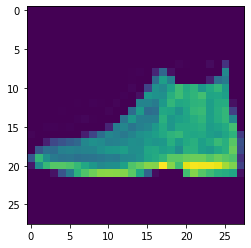

In [29]:
plt.imshow(image[0])

In [34]:
print(f"actual label: {dataset.classes[label]}, predicted label:{predict_single(image,model)}")

actual label: Ankle boot, predicted label:Ankle boot
